#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm

In [2]:
from numpy.linalg import eig, svd
from sklearn.decomposition import PCA

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [4]:
import copy

#### Test for CUDA

In [5]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


#### Data loader, train and test sets

In [6]:
batch_size = 200

In [7]:
# MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Classes in the MNIST dataset
classes = [str(x) for x in range(10)]
num_classes = len(classes)
classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [9]:
# Print some information about the datasets
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))
print("Number of classes:", num_classes)

Number of training examples: 60000
Number of test examples: 10000
Number of classes: 10


In [10]:
for d, l in train_loader:
    pass

Text(0.5, 1.0, 'Sequential MNIST Example: 2')

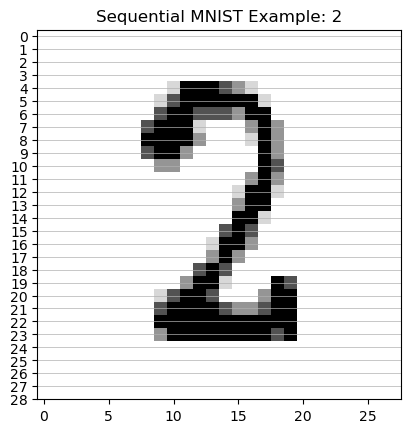

In [11]:
kk = 8
fimg = plt.figure()
plt.imshow(d[kk,0].numpy(),cmap='Greys')
plt.yticks(np.linspace(0, 28, 29))
plt.grid(axis='y',linewidth=0.5)
plt.title('Sequential MNIST Example: '+str(l[kk].numpy()))

#### Model and other hyper-params

In [12]:
# Hyperparameters
input_size = 28  # MNIST image size (28x28)
num_steps = 28
hidden_size = 128
num_layers = 1
num_epochs = 50
learning_rate = 0.001

In [13]:
nRuns = 5

In [14]:
N = hidden_size ## num. of neurons in RNN

In [15]:
def initialize_weights(N, index_ranges, signs):
    weights = np.zeros((N, N))
    for ii, (start, end) in enumerate(index_ranges):
        limit = 1 / np.sqrt(N) if signs[ii] == 1 else -1/np.sqrt(N)
        weights[:, start:end] = np.random.uniform(0, limit, size=(N, end-start))
    return weights

In [16]:
def generate_mask(weights, index_ranges, signs):
    mask = np.zeros_like(weights)
    for i, (start, end) in enumerate(index_ranges):
        if signs[i] == 1:
            mask[:, start:end] = np.where(weights[:, start:end] > 0, 1, 0)
        elif signs[i] == -1:
            mask[:, start:end] = np.where(weights[:, start:end] < 0, 1, 0)
    return mask

In [17]:
# Define the neural network
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, device):
        
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, num_classes)
        self.n_classes = num_classes
        self.device = device

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        nSamp, nSteps, inDim = x.shape
        
        ops = torch.zeros(nSamp,nSteps,self.hidden_size, requires_grad=False).to(self.device)
        pred = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        
        for ii in range(nSteps):
            ip = torch.unsqueeze(x[:,ii,:],1)
            op, ht = self.rnn(ip,h0) ## pass 1 timestep through RNN
            fr_mask = ht.clone()>0
            htt = fr_mask*ht.clone() ## mask firing rate
            h0 = htt ## update hidden state
            ops[:,ii,:] = torch.squeeze(op.clone())

            ## Final prediction at every timestep
            pred[:,ii,:] = self.fc(ops[:, ii, :].clone())
            
        out = pred[:, -1, :].clone()  #Take the output from the last time step
        
        return out, htt

In [18]:
frac_ex = 0.8
frac_in = 1-frac_ex

In [19]:
signs = [1,-1]
index_ranges = [(0,int(N*frac_ex)),(int(N*frac_ex),N)]

In [20]:
# Initialize the model
model = {}
weights_init = {}

In [21]:
for cntr in range(nRuns):
    model[cntr] = SimpleRNN(input_size, hidden_size, num_classes, device).to(device)
    weights_init[cntr] = initialize_weights(N,index_ranges,signs)
    model[cntr].rnn.weight_hh_l0.data = torch.from_numpy(weights_init[cntr]).float().to(device)

Text(0.5, 1.0, 'Initial Weights: Dales Backprop')

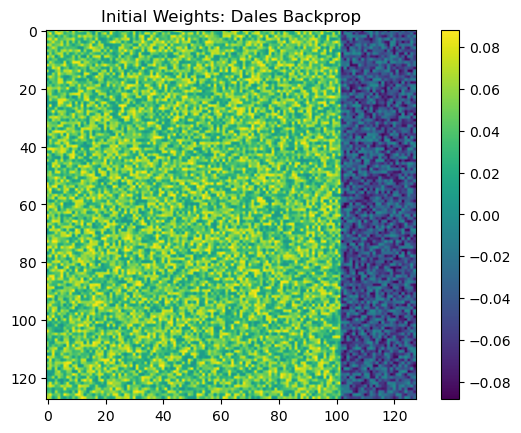

In [22]:
kk = 0

plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights: Dales Backprop')

#### Model training

In [23]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = {}
for cntr in range(nRuns):
    optimizer[cntr] = optim.Adam(model[cntr].parameters(), lr=learning_rate)

In [24]:
train_losses = np.zeros((nRuns, num_epochs))
test_losses = np.zeros((nRuns, num_epochs))
accuracies = np.zeros((nRuns, num_epochs))

In [ ]:
for run in tqdm(range(nRuns)):

    # Training the model
    for epoch in range(num_epochs):
        for ii, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28, 28).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs, firing_rates = model[run](images)
            loss = criterion(outputs, labels)
            train_losses[run,epoch] = loss

            # Backward and optimize
            optimizer[run].zero_grad()
            loss.backward()
            optimizer[run].step()

             ## Dale's Backprop
            w = model[run].rnn.weight_hh_l0.detach().cpu().numpy()
            mask = generate_mask(w, index_ranges, signs)
            wm = w*mask
            model[run].rnn.weight_hh_l0.data = torch.from_numpy(wm).float().to(device)

            if (ii+1) % batch_size == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Test the model
        with torch.no_grad():
            correct = 0
            total = 0
            for images_test, labels_test in test_loader:
                images_test = images_test.reshape(-1, 28, 28).to(device)
                labels_test = labels_test.to(device)
                outputs_test, firing_rates_test = model[run](images_test)
                loss_test = criterion(outputs_test, labels_test)
                test_losses[run,epoch] = loss_test
                ## accuracy
                _, predicted = torch.max(outputs_test.data, 1)
                total += labels_test.size(0)
                correct += (predicted == labels_test).sum().item()

            print(f'Accuracy of the network on the test images: {100 * correct / total}%')
            accuracies[run,epoch] = 100 * correct / total

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\abalwani6\AppData\Local\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:509: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch [1/50], Loss: 2.3011
Accuracy of the network on the test images: 10.28%
Epoch [2/50], Loss: 1.5469
Accuracy of the network on the test images: 41.82%
Epoch [3/50], Loss: 1.3251
Accuracy of the network on the test images: 52.45%
Epoch [4/50], Loss: 1.0883
Accuracy of the network on the test images: 62.36%
Epoch [5/50], Loss: 0.9996
Accuracy of the network on the test images: 68.3%
Epoch [6/50], Loss: 0.9231
Accuracy of the network on the test images: 70.15%
Epoch [7/50], Loss: 0.8032
Accuracy of the network on the test images: 74.39%
Epoch [8/50], Loss: 0.6924
Accuracy of the network on the test images: 77.17%
Epoch [9/50], Loss: 0.6484
Accuracy of the network on the test images: 79.9%
Epoch [10/50], Loss: 0.5541
Accuracy of the network on the test images: 81.44%
Epoch [11/50], Loss: 0.5072
Accuracy of the network on the test images: 80.59%
Epoch [12/50], Loss: 0.4292
Accuracy of the network on the test images: 83.47%
Epoch [13/50], Loss: 0.5315
Accuracy of the network on the test

 20%|██        | 1/5 [55:36<3:42:27, 3336.96s/it]

Accuracy of the network on the test images: 96.01%
Epoch [1/50], Loss: 2.2948
Accuracy of the network on the test images: 10.28%
Epoch [2/50], Loss: 1.7129
Accuracy of the network on the test images: 43.3%
Epoch [3/50], Loss: 1.3922
Accuracy of the network on the test images: 48.72%
Epoch [4/50], Loss: 1.2469
Accuracy of the network on the test images: 58.74%
Epoch [5/50], Loss: 1.0137
Accuracy of the network on the test images: 65.99%
Epoch [6/50], Loss: 0.8916
Accuracy of the network on the test images: 71.55%
Epoch [7/50], Loss: 0.7785
Accuracy of the network on the test images: 73.71%
Epoch [8/50], Loss: 0.7026
Accuracy of the network on the test images: 76.74%
Epoch [9/50], Loss: 0.5327
Accuracy of the network on the test images: 77.3%
Epoch [10/50], Loss: 0.5536
Accuracy of the network on the test images: 77.22%
Epoch [11/50], Loss: 0.4887
Accuracy of the network on the test images: 79.79%
Epoch [12/50], Loss: 0.5069
Accuracy of the network on the test images: 80.83%
Epoch [13/50

 40%|████      | 2/5 [1:40:14<2:27:26, 2948.89s/it]

Accuracy of the network on the test images: 95.08%
Epoch [1/50], Loss: 2.3128
Accuracy of the network on the test images: 19.13%
Epoch [2/50], Loss: 1.2830
Accuracy of the network on the test images: 55.09%
Epoch [3/50], Loss: 1.0856
Accuracy of the network on the test images: 66.35%
Epoch [4/50], Loss: 0.7878
Accuracy of the network on the test images: 70.99%
Epoch [5/50], Loss: 0.7446
Accuracy of the network on the test images: 73.49%
Epoch [6/50], Loss: 0.5903
Accuracy of the network on the test images: 78.37%
Epoch [7/50], Loss: 0.6418
Accuracy of the network on the test images: 80.44%
Epoch [8/50], Loss: 0.4358
Accuracy of the network on the test images: 81.91%
Epoch [9/50], Loss: 0.5026
Accuracy of the network on the test images: 81.82%
Epoch [10/50], Loss: 0.5422
Accuracy of the network on the test images: 83.61%
Epoch [11/50], Loss: 0.4419
Accuracy of the network on the test images: 84.95%
Epoch [12/50], Loss: 0.4358
Accuracy of the network on the test images: 87.14%
Epoch [13/

 60%|██████    | 3/5 [2:18:02<1:27:56, 2638.12s/it]

Accuracy of the network on the test images: 96.13%
Epoch [1/50], Loss: 2.2991
Accuracy of the network on the test images: 9.8%
Epoch [2/50], Loss: 1.7850
Accuracy of the network on the test images: 38.9%
Epoch [3/50], Loss: 1.4313
Accuracy of the network on the test images: 45.31%
Epoch [4/50], Loss: 1.2958
Accuracy of the network on the test images: 54.71%
Epoch [5/50], Loss: 1.0658
Accuracy of the network on the test images: 66.69%
Epoch [6/50], Loss: 0.9435
Accuracy of the network on the test images: 70.07%
Epoch [7/50], Loss: 0.9200
Accuracy of the network on the test images: 71.86%
Epoch [8/50], Loss: 0.6598
Accuracy of the network on the test images: 75.73%
Epoch [9/50], Loss: 0.8848
Accuracy of the network on the test images: 78.0%
Epoch [10/50], Loss: 0.5950
Accuracy of the network on the test images: 79.11%
Epoch [11/50], Loss: 0.7509
Accuracy of the network on the test images: 80.24%
Epoch [12/50], Loss: 0.5212
Accuracy of the network on the test images: 81.68%
Epoch [13/50],

 80%|████████  | 4/5 [2:56:03<41:37, 2497.05s/it]  

Accuracy of the network on the test images: 94.53%
Epoch [1/50], Loss: 2.3023
Accuracy of the network on the test images: 27.78%


In [ ]:
outputs_test_np = outputs_test.detach().cpu().numpy()
labels_test_np = labels_test.detach().cpu().numpy()
firing_rates_test_np = firing_rates_test.detach().cpu().numpy()

In [ ]:
weights_final = {}
for cntr in range(nRuns):
    weights_final[cntr] = model[cntr].rnn.weight_hh_l0.detach().cpu().numpy()

In [ ]:
mean_train_losses = np.mean(train_losses, axis=0)
variance_train_losses = np.var(train_losses, axis=0)

mean_test_losses = np.mean(test_losses, axis=0)
variance_test_losses = np.var(test_losses, axis=0)

mean_accs = np.mean(accuracies, axis=0)
variance_accs = np.var(accuracies, axis=0)

In [ ]:
# Define x-axis (epochs)
x = np.arange(num_epochs)

# Plot shaded error bar using Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=mean_train_losses, color='r')
plt.fill_between(x, mean_train_losses - np.sqrt(variance_train_losses), mean_train_losses + np.sqrt(variance_train_losses),
                 color='r', alpha=0.2)

# sns.lineplot(x=x, y=mean_test_losses, color='r')
# plt.fill_between(x, mean_test_losses - np.sqrt(variance_test_losses), mean_test_losses + np.sqrt(variance_test_losses),
#                  color='r', alpha=0.2)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Train Error')
plt.title('Loss Curve: Dales Backprop')

# Show plot
plt.show()

In [ ]:
# Define x-axis (epochs)
x = np.arange(num_epochs)

# Plot shaded error bar using Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=mean_accs, color='r')
plt.fill_between(x, mean_accs - np.sqrt(variance_accs), mean_accs + np.sqrt(variance_accs),
                 color='r', alpha=0.2)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy: Dales Backprop')

# Show plot
plt.show()

## Pruning

#### Define functions

In [ ]:
def random_prune(A, p):
    
    A += 1e-25
    
    # Ensure p is in the range [0, 1]
    p = max(0, min(1, p))
    # Adjust p based on the sparsity of the original matrix
    p_adjusted = -1.0 + np.sum(A!=0)/np.prod(A.shape) + p
    # Determine the threshold for setting elements to zero
    threshold = 1.0 - p_adjusted
    # Generate a random mask for sparsification
    mask = np.random.random(A.shape)
    # Set mask = 1 where A is already 0 and random elsewhere
    mask = np.where(A==0, 1, mask)
    # Apply the mask to the matrix to sparsify it
    sparsified_matrix = np.where(mask > threshold, A, 0)
    return sparsified_matrix

In [ ]:
def distribute_equally(arr):
    
    r = np.sum(np.where(arr>1, arr-1, 0))
    
    while r>0:
        # Count number of probs less than 1
        count_less_than_one = sum(1 for num in arr if num < 1)
        # Estimate delta to be added per number
        delta = 0
        if count_less_than_one > 0:
            delta = r/count_less_than_one
        # return new array with delta added appropriately
        arr = np.where(arr<1, arr+delta, 1)
        # calculate new residue
        r = np.sum(np.where(arr>1, arr-1, 0))
    
    return arr

In [ ]:
def topprob_prune(A, s):
    
    A += 1e-25
    
    N_post = A.shape[0]
    N_pre = A.shape[1]
    A_sparse = np.zeros_like(A)
    
    z0 = np.sum(A==0) + np.min((N_pre,N_post))
    if z0 > 0:
        z = s*np.prod(A.shape)
        s = (z-z0)/(np.prod(A.shape)-z0)
    
    if N_post == N_pre:
        D = -1*np.diag(np.diag(A))
        W = A #+ D
    else:
        d_vals = -1*np.diag(A)
        D = np.zeros_like(A)
        np.fill_diagonal(D, d_vals)
        W = A #+ D
    
    K = N_pre*N_post*(1-s)/np.sum(np.abs(W))
    Pmat = np.zeros_like(W)
    
    for ii in range(N_post):
        for jj in range(N_pre):
            
            if np.abs(W[ii,jj])>0:
                Pij = K*(np.abs(W[ii,jj]))
                Pmat[ii,jj] = Pij
    
    Pmat_adjusted = distribute_equally(Pmat.ravel())
    Pmat_adjusted = Pmat_adjusted.reshape(N_post, N_pre)
                
    for ii in range(N_post):
        for jj in range(N_pre):
            if np.abs(W[ii,jj])>0:
                Pij = Pmat_adjusted[ii,jj]    
                if np.random.uniform() < Pij:
                    A_sparse[ii,jj] = A[ii,jj]
    
    return A_sparse, K

#### Trials

In [ ]:
rr = 0
prob_trial = 0.
s_trial = 1 - prob_trial

In [ ]:
A_trial = weights_final[rr]

# trial with random pruning
A_trial_random = random_prune(A_trial,prob_trial)

## trial with topprob pruning
A_trial_topprob, _ = topprob_prune(A_trial,s_trial)

In [ ]:
print(np.sum(A_trial_random==0)/N**2)
print(np.sum(A_trial_topprob==0)/N**2)

#### Prune using final weights

In [ ]:
prob_list = np.linspace(1e-2, 1, 14)
prob_list = np.hstack((np.zeros(1),prob_list))
s_list = 1-prob_list

In [ ]:
print('Conn probs = ', prob_list)
print('--------------------------------')
print('--------------------------------')
print('Sparisties = ', s_list)

In [ ]:
n = len(prob_list)

sparsities_list_random = np.zeros((nRuns,n))
sparsities_list_topprob = np.zeros((nRuns,n))

A_pruned_list_random = np.zeros((nRuns,n,N,N))
A_pruned_list_topprob = np.zeros((nRuns,n,N,N))

errors_list_random = np.zeros((nRuns,n))
errors_list_topprob = np.zeros((nRuns,n))

In [ ]:
# Initialize the model
mp_random = {}
mp_topprob = {}

In [ ]:
for run in tqdm(range(nRuns)):
    A = weights_final[run]
    
    mp_random[run] = copy.deepcopy(model[run])
    mp_topprob[run] = copy.deepcopy(model[run])
    
    for ii, pp in enumerate(prob_list):
        ss = s_list[ii]
        A_pruned_list_random[run,ii] = random_prune(A,pp)
        A_pruned_list_topprob[run,ii], _ = topprob_prune(A,ss)
        
        sparsities_list_random[run,ii] = np.sum(A_pruned_list_random[run,ii]==0)/N**2
        sparsities_list_topprob[run,ii] = np.sum(A_pruned_list_topprob[run,ii]==0)/N**2
        
        mp_random[run].rnn.weight_hh_l0.data = mp_random[run].rnn.weight_hh_l0.data.copy_(torch.from_numpy(A_pruned_list_random[run,ii]).cuda())
        op_random, frp = mp_random[run](images_test)
        errors_list_random[run,ii] = criterion(op_random.cuda(), labels_test)
        
        mp_topprob[run].rnn.weight_hh_l0.data = mp_topprob[run].rnn.weight_hh_l0.data.copy_(torch.from_numpy(A_pruned_list_topprob[run,ii]).cuda())
        op_topprob, frp = mp_topprob[run](images_test)
        errors_list_topprob[run,ii] = criterion(op_topprob.cuda(), labels_test)

In [ ]:
xtick_labels = [str(np.round(k,3)) for k in prob_list]
xtick_positions = np.arange(len(prob_list))

In [ ]:
# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot the first dataset using the first axis
ax.errorbar(np.arange(len(prob_list)), np.mean(errors_list_random,0), yerr=np.std(errors_list_random,0), fmt='o', capsize=3, color='r')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels,rotation=65)
ax.set_ylabel('Errors', color='r')

# Create a second axis sharing the same x-axis
ax2 = ax.twinx()
ax2.errorbar(np.arange(len(prob_list)), np.mean(sparsities_list_random,0), yerr=np.std(sparsities_list_random,0), fmt='x', capsize=3, color='g')
ax2.set_ylabel('Sparsities', color='g')


ax.set_title('Performance with sparsity: Random')
ax.set_xlabel('Probability of connection')
plt.show()

In [ ]:
# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot the first dataset using the first axis
ax.errorbar(np.arange(len(s_list)), np.mean(errors_list_topprob,0), yerr=np.std(errors_list_topprob,0), fmt='o', capsize=3, color='r')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels,rotation=65)
ax.set_ylabel('Errors', color='r')

# Create a second axis sharing the same x-axis
ax2 = ax.twinx()
ax2.errorbar(np.arange(len(s_list)), np.mean(sparsities_list_topprob,0), yerr=np.std(sparsities_list_topprob,0), fmt='x', capsize=3, color='g')
ax2.set_ylabel('Sparsities', color='g')


ax.set_title('Performance with sparsity: Top-prob')
ax.set_xlabel('Probability of connection')
plt.show()

In [ ]:
fig, ax = plt.subplots()

plt.errorbar(np.arange(len(s_list)), np.mean(sparsities_list_topprob,0), yerr=np.var(sparsities_list_topprob,0),
             fmt='x', capsize=3, color='g', label='Top-prob sparsity')
plt.errorbar(np.arange(len(prob_list)), np.mean(sparsities_list_random,0), yerr=np.var(sparsities_list_random,0),
             fmt='x', capsize=3, color='grey', label='Random sparsity')
plt.plot(np.arange(len(prob_list)), s_list, label = 'Expected sparsity')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels,rotation=65)

plt.legend()
plt.ylabel('Sparsity')
plt.xlabel('Probability of connection')
plt.title('Sparsity vs. Probability of connection')

In [ ]:
fig, ax = plt.subplots()

plt.errorbar(np.arange(len(s_list)), np.mean(errors_list_topprob,0), yerr=np.std(errors_list_topprob,0),
             fmt='o', capsize=3, color='g', label='Top-prob')
plt.errorbar(np.arange(len(prob_list)), np.mean(errors_list_random,0), yerr=np.std(errors_list_random,0),
             fmt='o', capsize=3, color='grey', label='Random')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels,rotation=65)

plt.legend()
plt.ylabel('Errors')
plt.xlabel('Connection probabilities')

In [ ]:
# np.save('errors_list_random_seq_mnist.npy',errors_list_random)
# np.save('errors_list_topprob_seq_mnist.npy',errors_list_topprob)

In [ ]:
means = [np.mean(errors_list_topprob), np.mean(errors_list_random)]
devs = [np.std(errors_list_topprob), np.std(errors_list_random)]

In [ ]:
labels = ['Top-prob','Random']
x_pos = np.arange(len(labels))

colours = ['g','grey']

In [ ]:
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=devs, align='center', alpha=0.7, ecolor='black', capsize=10, color=colours)

# Add labels and title
ax.set_ylabel('Mean error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Sequential MNIST: Error with pruned model')

#### Retraining: random training vs topprob training

In [ ]:
min_losses = {}
for cntr in range(nRuns):
    min_losses[cntr] = test_losses[cntr][-1]
avg_min = sum(min_losses.values())/nRuns

In [ ]:
min_losses

In [ ]:
n_fine = 25

In [ ]:
def retrain(mp, pruned_rnn_weights, train_loss_min, train_loader, test_loader, num_epochs_finetune=n_fine):
    
    rnn_mask = torch.from_numpy((pruned_rnn_weights!=0).astype(int)).cuda()
    
    mp.rnn.weight_hh_l0.data = mp.rnn.weight_hh_l0.data.copy_(torch.from_numpy(pruned_rnn_weights).cuda())
    finetune_optimizer = optim.Adam(mp.parameters(), lr=learning_rate)
    
    test_losses = np.zeros((num_epochs_finetune))
    
    mp.train()
    for epoch in (range(1, num_epochs_finetune+1)):
        print(epoch)
    
        train_loss = 0.0
        test_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs = inputs.reshape(-1, 28, 28).to(device)
            targets = targets.to(device)

            finetune_optimizer.zero_grad()
            oops, frps = mp(inputs)
            if train_on_gpu:
                oops = oops.cuda()
            loss = criterion(oops, targets)
            loss.backward()
            finetune_optimizer.step()
            train_loss += loss.item()

            ## Dale's backprop
            w = mp.rnn.weight_hh_l0.detach().cpu().numpy()
            mask = generate_mask(w, index_ranges, signs)
            wm = w*mask
            mp.rnn.weight_hh_l0.data = torch.from_numpy(wm).float().cuda()

            ## make sure sparsity mask is applied
            mp.rnn.weight_hh_l0.data = rnn_mask*mp.rnn.weight_hh_l0.data

        if train_loss< train_loss_min:
            print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            train_loss_min = train_loss
        
        for inputs_test, targets_test in test_loader:
            inputs_test = inputs_test.reshape(-1, 28, 28).to(device)
            targets_test = targets_test.to(device)

            oops_test, frps_test = mp(inputs_test)
            if train_on_gpu:
                oops_test = oops_test.cuda()
            loss_test = criterion(outputs_test, targets_test)
            test_loss += loss_test.item()
            
        test_losses[epoch-1] = test_loss
        print(test_loss)
            
    return mp, test_losses

In [ ]:
model_finetuned_random = {}
model_finetuned_topprob = {}

test_losses_finetuned_random = {}
test_losses_finetuned_topprob = {}

In [ ]:
## retrain from ~90% sparse 

for run in tqdm(range(nRuns)):
    model_finetuned_random[run], test_losses_finetuned_random[run] = retrain(copy.deepcopy(model[run]), A_pruned_list_random[run][2], min_losses[run], train_loader, test_loader)
    model_finetuned_topprob[run], test_losses_finetuned_topprob[run] = retrain(copy.deepcopy(model[run]), A_pruned_list_topprob[run][2], min_losses[run], train_loader, test_loader)

In [ ]:
test_losses_finetuned_random_np = np.zeros((nRuns,n_fine))
test_losses_finetuned_topprob_np = np.zeros((nRuns,n_fine))

for cntr in range(nRuns):
    test_losses_finetuned_random_np[cntr] = test_losses_finetuned_random[cntr]
    test_losses_finetuned_topprob_np[cntr] = test_losses_finetuned_topprob[cntr]

In [ ]:
fig, ax = plt.subplots()

plt.errorbar(np.arange(n_fine), np.mean(train_losses_finetuned_topprob_np,0), yerr=np.var(train_losses_finetuned_topprob_np,0),
             fmt='o', capsize=3, color='g', label='Top-prob')
plt.errorbar(np.arange(n_fine), np.mean(train_losses_finetuned_random_np,0), yerr=np.var(train_losses_finetuned_random_np,0),
             fmt='o', capsize=3, color='grey', label='Random')
plt.plot(np.arange(n_fine),[avg_min]*n_fine,'--',color='k',label='Original min. loss')

plt.legend()
plt.ylabel('Errors')
plt.xlabel('Epochs retrained')
plt.title('0.9 Sparsity Losses with retraining: Sequential MNIST')